### importing required packages

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

### Getting lr and hr

In [1]:
train_dir=r"D:\research1\data"

In [8]:
import os
import cv2
import numpy as np

train_dir = "D:/research1/data/"
hr_dir = "D:/research1/data/hr_images"
lr_dir = "D:/research1/data/lr_images"

if not os.path.exists(hr_dir):
    os.makedirs(hr_dir)

if not os.path.exists(lr_dir):
    os.makedirs(lr_dir)

def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

for img in os.listdir(train_dir + "/original_images"):
    img_array = cv2.imread(os.path.join(train_dir, "original_images", img))

    if img_array is not None:
        # Resize to high resolution (HR)
        hr_img_array = cv2.resize(img_array, (369, 108))

        # Resize to low resolution (LR) and add noise & blur
        lr_img_array = cv2.resize(img_array, (92, 27))
        lr_img_array = add_noise(lr_img_array)
        lr_img_array = add_blur(lr_img_array)

        # Save HR and LR images
        cv2.imwrite(os.path.join(hr_dir, img), hr_img_array)
        cv2.imwrite(os.path.join(lr_dir, img), lr_img_array)

print("Dataset created successfully!")

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [4]:
for img in os.listdir( train_dir + "/original_images"): 
    img_array = cv2.imread(train_dir + "/original_images/"+img)

    img_array = cv2.resize(img_array, (128,128)) 
    lr_img_array = cv2.resize(img_array, (32,32)) 
    cv2.imwrite(r"D:\research1\data\hr_images"+img, img_array) 
    cv2.imwrite(r"D:\research1\data\lr_images"+ img, lr_img_array)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


## model

Define blocks to build the generator

In [5]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [6]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

### creation of generator

In [7]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

### discriminator

In [8]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [9]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)  #it will give one output 1 if it is matched....

    return Model(disc_ip, validity)

### vgg16


We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
Let us pick the 3rd block, last conv layer. 
Build a pre-trained VGG19 model that outputs image features extracted at the
third block of the model
VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py

In [10]:
from keras.applications import VGG19


In [11]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)  #weights where taken from imagenet i.e it is trained on millions of dataset
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

## Combined model


In [12]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)    #as we know it is generating a new img
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)   #that we are passing in discriminator and it will say it is a real or fake one... in below that we are passing as input to find the loss fn.[validity] 
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])  #[gen_features] is a vgg feauters

# Training

using low resolution one 

In [13]:
n=634
lr_list = os.listdir(r"D:\research1\data\lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(r"D:\\research1\\data\\lr_images\\"+ img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)  ##it will convert image bgr to rgb and it is gud for displaying purposes
    lr_images.append(img_lr) 

using high resolution one 

In [14]:
hr_list = os.listdir(r"D:\research1\data\hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(r"D:\\research1\\data\\hr_images\\" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr) 

In [15]:
#converting into numpy array's
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

### ploting some of the images

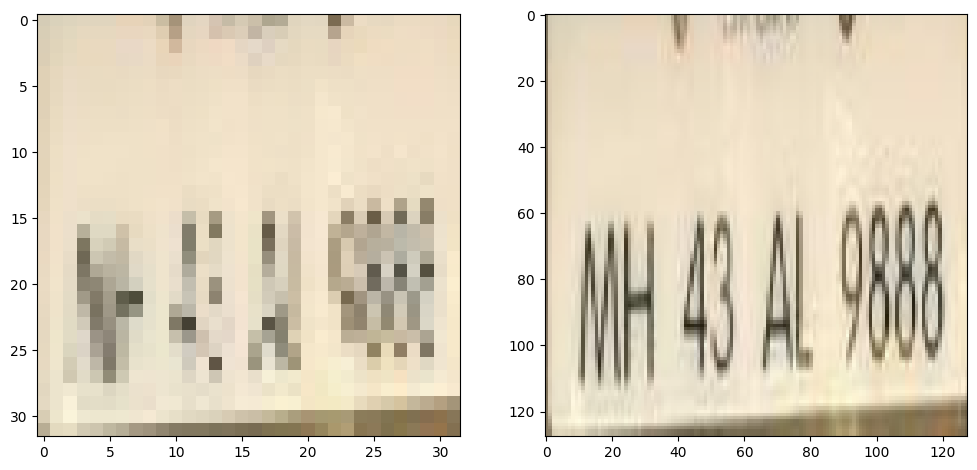

In [16]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [17]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.  #ranges b/w 0 to 255 if we r using tanh as activation fn for that it is different that values lies b/w -1 to 1 but wht we get here the values range b/w 0 to 1

### train_test split

In [18]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,test_size=0.20, random_state=42)

In [19]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3]) #basically we are getting the shape of low_res and high_res images

In [20]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [21]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])  #it uses binary cross entopy because it is binary class problem
discriminator.summary()

d:\GANlpr\gan\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,80

 Total params: 38,249,281 (145.91 MB)

 Trainable params: 38,245,569 (145.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [22]:
vgg = build_vgg((128,128,3))  #here we are extracting the feture of hig_res image thats why we are using 128 and keeping that aside from generator we will getting images from there again we r xtracting the features and comparing the features
print(vgg.summary())
vgg.trainable = False

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
#now we r creating gan model
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


In [24]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()
#why binary cross here in the sense check the gan model we have craeated there we use 'validity' as a loss fn-- that is basically output of the discriminator and mse for vgg... 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128, 128,  │  2,044,291 │ input_layer[0][0] │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │ 38,249,281 │ functional[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 32, 32,    │  2,325,568 │ functional[0][0]  │
│ (Functional)        │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,619,140 (162.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 40,579,073 (154.80 MB)

batch and epoches

In [25]:
batch_size = 1   #these gives the best result by read a couple of papers
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])  #or if we want we can create batches of images to train like 10 low_res images corresponding 10 high_res images 
#wht above code will do in the sense it will train 1 image at a time and send it to below i.e discriminator

In [26]:
epochs = 2

In [27]:
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []  #empty list to capture the looses as we mentione befor
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))): ##here we r going to each batch i.e each of 634 imgs
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images ##as w.k we r supplying low_res image to generator it will presict on it and then it will pass to discriminator
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label) #for comparing purposes we taken high_res img
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. ##if generator trained only discrimator will do his job na
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)  #discrimator loss and ...
        g_losses.append(g_loss)
    
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)  #at the end of each epoch we r avg. them
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)


    generator.save("gen_e_"+ str(e+1) +".h5")


  0%|          | 0/507 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


  0%|          | 1/507 [01:27<12:15:38, 87.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  0%|          | 2/507 [02:29<10:10:44, 72.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  1%|          | 3/507 [03:29<9:22:48, 67.00s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  1%|          | 4/507 [04:30<9:01:20, 64.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  1%|          | 5/507 [05:30<8:44:47, 62.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  1%|          | 6/507 [06:30<8:35:41, 61.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  1%|▏         | 7/507 [07:29<8:27:52, 60.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  2%|▏         | 8/507 [08:28<8:23:11, 60.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  2%|▏         | 9/507 [09:29<8:21:20, 60.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  2%|▏         | 10/507 [10:30<8:22:24, 60.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  2%|▏         | 11/507 [11:29<8:18:29, 60.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  2%|▏         | 12/507 [12:30<8:19:06, 60.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 13/507 [13:32<8:20:15, 60.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  3%|▎         | 14/507 [14:32<8:17:19, 60.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  3%|▎         | 15/507 [15:33<8:18:14, 60.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  3%|▎         | 16/507 [16:39<8:29:37, 62.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  3%|▎         | 17/507 [17:38<8:20:52, 61.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  4%|▎         | 18/507 [18:44<8:30:55, 62.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▎         | 19/507 [20:05<9:14:23, 68.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


  4%|▍         | 20/507 [21:45<10:31:25, 77.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  4%|▍         | 21/507 [23:00<10:24:35, 77.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


### test

In [33]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [34]:
generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


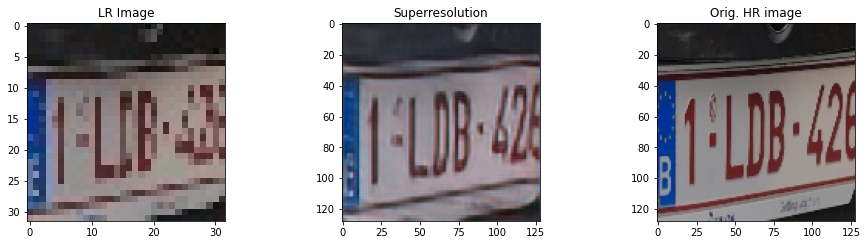

In [35]:
# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()